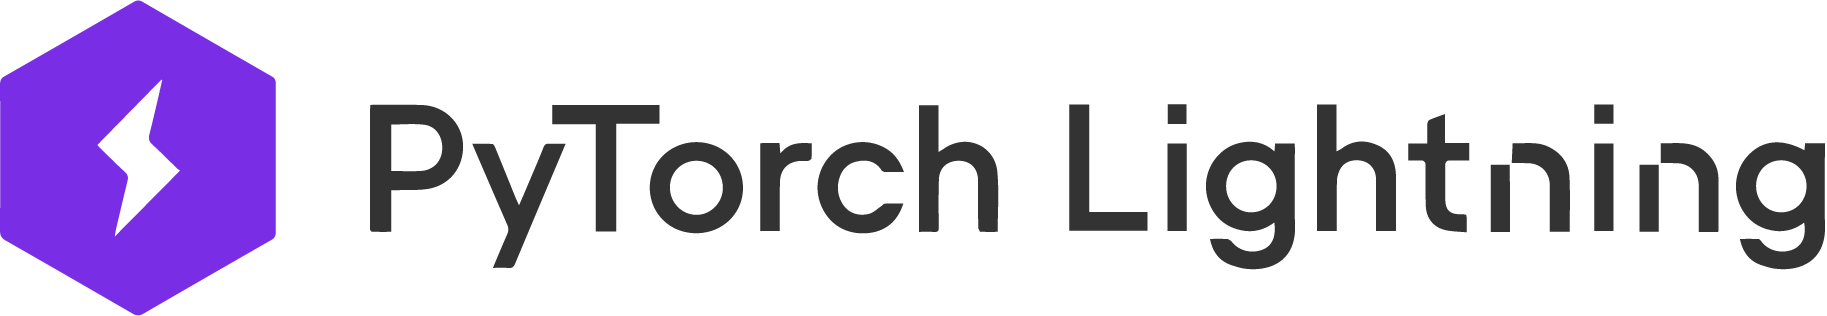

Run in yourown colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/huanchen1107/2022_DRL/blob/main/2_9_dqn_pytorch_lightning_tensorboardOK_moreComments.ipynb)

# **Box2D BipedalWalker**





# **1. Setup Environment**

In [ ]:
!apt-get install -y xvfb
!pip install gym==0.21 gym[box2d] pytorch-lightning==1.6.0 pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **2. Setup virtual display**

In [ ]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

In [ ]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

# **3. Import the necessary code libraries**

In [ ]:
import copy
import gym
import torch
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule,Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

from pytorch_lightning.callbacks import EarlyStopping

import datetime
import pickle
import math


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

# **4. Create the Deep Q-Network**

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(DQN, self).__init__()
        self.l1 = nn.Linear(state_dim, 300)
        self.l2 = nn.Linear(300, 400)
        self.l3 = nn.Linear(400, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = self.l1(state)
        x = F.relu(x)
        x = F.relu(self.l2(x))
        x = self.max_action * torch.tanh(self.l3(x))
        return x

# **5. Create the policy**

In [ ]:
def epsilon_greedy(state, env, net, epsilon=0.0):
  # With probability EPSILON, select a random action
  if np.random.random() > epsilon:
    action = env.action_space.sample()
  # Otherwise select the action with the highest Q value
  else:
    state = torch.tensor([state]).to(device) 
    q_value = net(state)                       
    action = torch.max(q_value, 0)[0].data.numpy()                
  return action

# **6. Create the replay buffer**

In [ ]:
class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer= deque(maxlen=capacity)
  
  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience) 

  def sample(self,batch_size):
    return random.sample(self.buffer,batch_size) 

In [ ]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=200):
     self.buffer = buffer
     self.sample_size = sample_size
    
  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

# **7. Create the environment**

In [ ]:
def create_environment(name):
  env=gym.make(name)
  env=TimeLimit(env, max_episode_steps=400)
  record_interval=100
  env=RecordVideo(env, video_folder='./videos',episode_trigger=lambda x: x% record_interval==0)
  env=RecordEpisodeStatistics(env)
  return env

###**Description**
This is a simple 4-joint walker robot environment. There are two versions:
* Normal: with slightly uneven terrain.
* Hardcore: with ladders, stumps, pitfalls.

To solve the normal version, you need to get 300 points in 1600 time steps.

To solve the hardcore version, you need 300 points in 2000 time steps.

###**Action Space**
BipedalWalker has 2 legs. Each leg has 2 joints. You have to teach the Bipedal-walker to walk by applying the torque on these joints. Therefore the size of our action space is 4 which is torque applied on 4 joints. You can apply the torque in the range of (-1, 1)
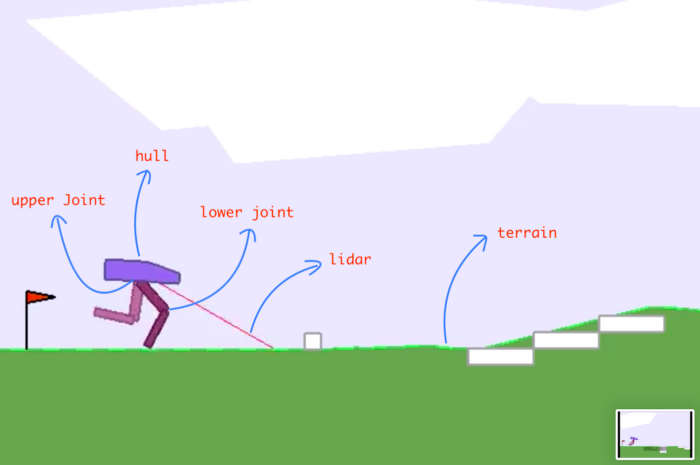

###**Observation Space**
State consists of
* Hull angle speed
* Angular velocity
* Horizontal speed
* Vertical speed
* Position of joints
* Joints angular speed
* Legs contact with ground
* 10 lidar rangefinder measurements

There are no coordinates in the state vector.

###**Rewards**
* Reward is given for moving forward, totaling 300+ points up to the far end.
* If the robot falls, it gets -100.

Applying motor torque costs a small amount of points. A more optimal agent will get a better score.

###**Starting State**
The walker starts standing at the left end of the terrain with the hull horizontal, and both legs in the same position with a slight knee angle.

###**Episode Termination**
The episode will terminate if the hull gets in contact with the ground or if the walker exceeds the right end of the terrain length.

###**Arguments**
To use to the _hardcore_ environment, you need to specify the `hardcore=True` argument like below:
```python
import gym
env = gym.make("BipedalWalker-v3", hardcore=True)
```

# **8. Create the Deep Q-Learning algorithm**

In [ ]:
from torch.optim.adam import Adam
class DeepQLearning(LightningModule):

  #initialize
  def __init__(self, env_name, policy=epsilon_greedy, capacity=100_000, batch_size=64,lr=1e-5, 
          gamma=0.9,loss_fn=F.smooth_l1_loss, optim=Adam, 
          eps_start=1.0,eps_end=0.15,eps_last_episode=100,samples_per_epoch=10_000,sync_rate=10):
    
    super().__init__()
    self.env=create_environment(env_name)

    obs_size = self.env.observation_space
    n_actions = self.env.action_space

    self.q_net=DQN(obs_size.shape[0], n_actions.shape[0], n_actions.high[0]).to(device)

    self.target_q_net= copy.deepcopy(self.q_net)

    self.policy =policy
    self.buffer=ReplayBuffer(capacity=capacity)
    self.save_hyperparameters()

    while len(self.buffer)<self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in expereience buffer. Filling ...")
      self.play_episode(epsilon=self.hparams.eps_start)

  @torch.no_grad()
  def play_episode(self, policy=None, epsilon=0.):
    state= self.env.reset()
    done=False
      
    while not done:
      if policy:
        action=policy(state, self.env, self.q_net,epsilon=epsilon)
      else:
        action=self.env.action_space.sample()

      # Execute the action in env and observe reward and next state
      next_state, reward, done, info=self.env.step(action)
      exp = (state, action, reward, next_state)

      # Stores experiences in buffer
      self.buffer.append(exp)

      # Update variables each step
      state=next_state

  #Forward path
  def forward(self, x):
    return self.q_net(x)

  #Config optimumizer
  def configure_optimizers(self):
    q_net_optimizer=self.hparams.optim(self.q_net.parameters(),lr=self.hparams.lr)
    return [q_net_optimizer]

  #prepare training state using data loader
  def train_dataloader(self):
    dataset=RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader=DataLoader(dataset=dataset,batch_size=self.hparams.batch_size)
    return dataloader

  # training step
  def training_step(self,batch,batch_idx):
    states, actions, rewards, next_states = batch
    states = torch.tensor(states).float().to(device)
    actions = torch.tensor(actions).long().to(device)
    rewards = rewards.unsqueeze(1)
    next_states = torch.tensor(next_states).float().to(device)

    state_action_values=self.q_net(states)
    next_action_values, _ =self.target_q_net(next_states).max(dim=1,keepdim=True)

    expected_state_action_values = rewards+ self.hparams.gamma*next_action_values
    loss=self.hparams.loss_fn(state_action_values, expected_state_action_values)
    self.log('episode/Q-Error',loss)
    return loss

  #training end 
  def training_epoch_end(self, training_step_outputs):

    epsilon= max(
      self.hparams.eps_end,
      self.hparams.eps_start-self.current_epoch/self.hparams.eps_last_episode
    )
    self.play_episode(policy=self.policy, epsilon=epsilon)
    self.log('episode/Return', self.env.return_queue[-1])

    if self.current_epoch % self.hparams.sync_rate==0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())



# **9. Train the policy**

In [ ]:
algo = DeepQLearning('BipedalWalker-v3')
trainer= Trainer(
    gpus=num_gpus,
    max_epochs=2000,
    callbacks=[EarlyStopping(monitor='episode/Return',mode='max', patience=500)]
)
trainer.fit(algo)

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


0 samples in expereience buffer. Filling ...
82 samples in expereience buffer. Filling ...
482 samples in expereience buffer. Filling ...
558 samples in expereience buffer. Filling ...
644 samples in expereience buffer. Filling ...
722 samples in expereience buffer. Filling ...
1122 samples in expereience buffer. Filling ...
1522 samples in expereience buffer. Filling ...
1629 samples in expereience buffer. Filling ...
1716 samples in expereience buffer. Filling ...
1773 samples in expereience buffer. Filling ...
2173 samples in expereience buffer. Filling ...
2573 samples in expereience buffer. Filling ...
2622 samples in expereience buffer. Filling ...
3022 samples in expereience buffer. Filling ...
3078 samples in expereience buffer. Filling ...
3133 samples in expereience buffer. Filling ...
3533 samples in expereience buffer. Filling ...
3933 samples in expereience buffer. Filling ...
4000 samples in expereience buffer. Filling ...
4400 samples in expereience buffer. Filling ...
4

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type | Params
--------------------------------------
0 | q_net        | DQN  | 129 K 
1 | target_q_net | DQN  | 129 K 
--------------------------------------
259 K     Trainable params
0         Non-trainable params
259 K     Total params
1.036     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 4])). This will likely lead to incorrect res

# **10. Check the resulting policy**

In [ ]:
display_video(episode=500)

# **11. Run the visualization tool (Tensorboard)**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/ --bind_all